In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import random
import os
from time import time 

In [2]:

LOAD_DIR = r'C:\Users\elefa\Documents\local_dir\local_python_code\mini_proj_data\modified_swiss_dwellings'
#load one building to check working directory
bid = '23'  
domain = np.load(join(LOAD_DIR, f'{bid}_domain.npy'))
interior = np.load(join(LOAD_DIR, f'{bid}_interior.npy'))

#define functions to load data
def load_building_data(load_dir, building_id):
    SIZE = 512
    u = np.zeros((SIZE + 2, SIZE + 2))  # padded array
    u[1:-1, 1:-1] = np.load(join(load_dir, f"{building_id}_domain.npy"))
    interior_mask = np.load(join(load_dir, f"{building_id}_interior.npy"))
    return u, interior_mask
 

In [3]:

def plot_building(u, interior_mask, building_id, output_dir="figures"):
    os.makedirs(output_dir, exist_ok=True)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    im0 = axs[0].imshow(u[1:-1, 1:-1], cmap='coolwarm', vmin=0, vmax=30)
    axs[0].set_title(f"Initial Temperature Grid\n(Building {building_id})")
    plt.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(interior_mask, cmap='gray')
    axs[1].set_title(f"Interior Mask\n(Building {building_id})")
    plt.colorbar(im1, ax=axs[1])

    plt.tight_layout()
    save_path = os.path.join(output_dir, f"building_{building_id}.png")
    plt.savefig(save_path)
    print(f"Saved: {save_path}")
    plt.close()


def visualize_sim(u, bid):
    """
    Visualizes the simulation results.
    
    Parameters:
    - u: 2D numpy array representing the simulation results.
    - bid: str, building ID for the title.
    """
    plt.figure(figsize=(5, 5))
    plt.title(f"Simulation Results of Building {bid}")
    
    # Use perceptually clear temperature colormap
    plt.imshow(u, cmap='inferno', vmin=0, vmax=25)
    plt.colorbar(label='Temperature (°C)')
    plt.show()
    # Save the visualization
    output_dir = "visualizations"
    os.makedirs(output_dir, exist_ok=True)
    save_path = os.path.join(output_dir, f"simulation_{bid}.png")
    plt.savefig(save_path)
    print(f"Saved: {save_path}")


In [4]:
example_building_ids = ['25806', '28082', '6086']  # Replace with real IDs available to you

for bid in example_building_ids:
    u, mask = load_building_data(LOAD_DIR, bid)
    plot_building(u, mask, bid)

Saved: figures\building_25806.png
Saved: figures\building_28082.png
Saved: figures\building_6086.png


SIMULATE FUNCTIONS 

In [4]:
def load_data(load_dir, bid):
    SIZE = 512
    u = np.zeros((SIZE + 2, SIZE + 2))
    u[1:-1, 1:-1] = np.load(join(load_dir, f"{bid}_domain.npy"))
    interior_mask = np.load(join(load_dir, f"{bid}_interior.npy"))
    return u, interior_mask


def jacobi(u, interior_mask, max_iter, atol=1e-6):
    u = np.copy(u)

    for i in range(max_iter):
        # Compute average of left, right, up and down neighbors, see eq. (1)
        u_new = 0.25 * (u[1:-1, :-2] + u[1:-1, 2:] + u[:-2, 1:-1] + u[2:, 1:-1])
        u_new_interior = u_new[interior_mask]
        delta = np.abs(u[1:-1, 1:-1][interior_mask] - u_new_interior).max()
        u[1:-1, 1:-1][interior_mask] = u_new_interior

        if delta < atol:
            break
    return u


def summary_stats(u, interior_mask):
    u_interior = u[1:-1, 1:-1][interior_mask]
    mean_temp = u_interior.mean()
    std_temp = u_interior.std()
    pct_above_18 = np.sum(u_interior > 18) / u_interior.size * 100
    pct_below_15 = np.sum(u_interior < 15) / u_interior.size * 100
    return {
        'mean_temp': mean_temp,
        'std_temp': std_temp,
        'pct_above_18': pct_above_18,
        'pct_below_15': pct_below_15,
    }   

In [12]:
# DECIDE N
N = 4

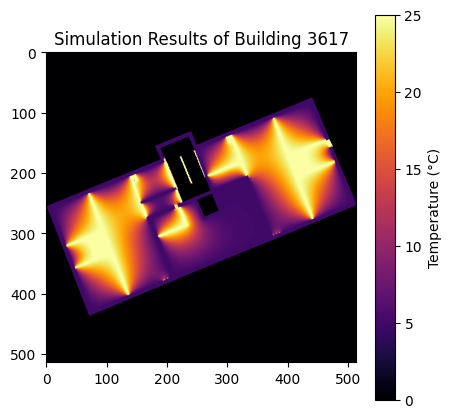

Saved: visualizations\simulation_3617.png


<Figure size 640x480 with 0 Axes>

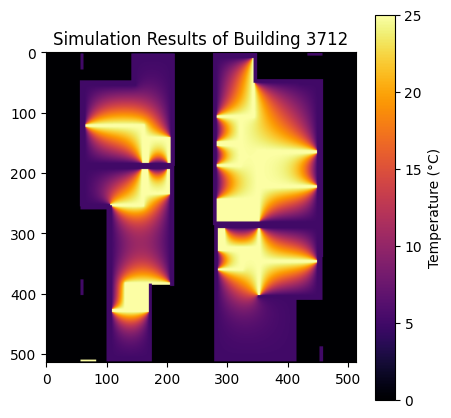

Saved: visualizations\simulation_3712.png


<Figure size 640x480 with 0 Axes>

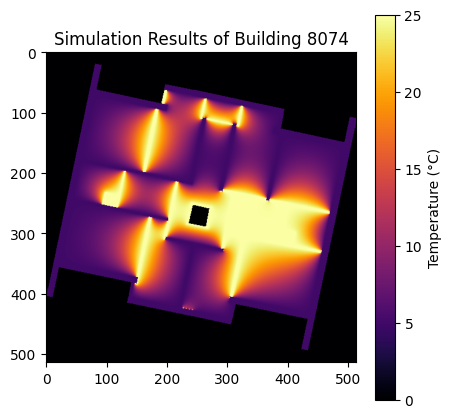

Saved: visualizations\simulation_8074.png


<Figure size 640x480 with 0 Axes>

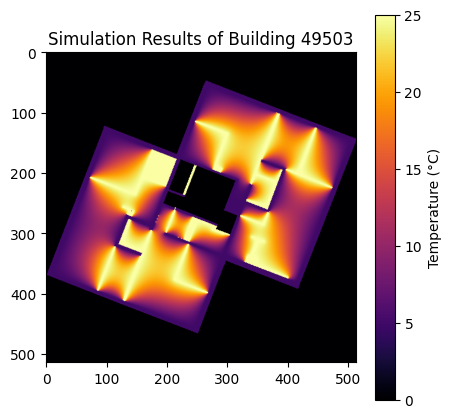

Saved: visualizations\simulation_49503.png
building_id, mean_temp, std_temp, pct_above_18, pct_below_15
3617, 14.280047868975226, 6.803103624167419, 36.93999008100513, 53.07902132583898
3712, 14.28058383740839, 7.1676726214985225, 36.37072279117275, 55.23389690795545
8074, 12.72910708331481, 6.761088291041249, 26.557716282343762, 65.87823225598535
49503, 15.529177837050256, 6.380790677919235, 42.08779798542052, 47.01506117599203


<Figure size 640x480 with 0 Axes>

In [ ]:
with open(join(LOAD_DIR, 'building_ids.txt'), 'r') as f:
    building_ids = f.read().splitlines()

building_ids = random.sample(building_ids, N)

# Load floor plans
all_u0 = np.empty((N, 514, 514))
all_interior_mask = np.empty((N, 512, 512), dtype='bool')
for i, bid in enumerate(building_ids):
    u0, interior_mask = load_data(LOAD_DIR, bid)
    all_u0[i] = u0
    all_interior_mask[i] = interior_mask

# Run jacobi iterations for each floor plan
MAX_ITER = 20_000
ABS_TOL = 1e-4

all_u = np.empty_like(all_u0)
for i, (u0, interior_mask) in enumerate(zip(all_u0, all_interior_mask)):
    u = jacobi(u0, interior_mask, MAX_ITER, ABS_TOL)
    all_u[i] = u
    visualize_sim(u, building_ids[i])

# Print summary statistics in CSV format
stat_keys = ['mean_temp', 'std_temp', 'pct_above_18', 'pct_below_15']
print('building_id, ' + ', '.join(stat_keys))  # CSV header
for bid, u, interior_mask in zip(building_ids, all_u, all_interior_mask):
    stats = summary_stats(u, interior_mask)
    print(f"{bid},", ", ".join(str(stats[k]) for k in stat_keys))